### ปฏิบัติการครั้งที่ 9

ดาวน์โหลดข้อมูลอุณหภูมิสูงสุดรายวันปี 1998-2019 จาก link ข้างล่างนี้  
https://donlapark.pages.dev/229351/data/CM_temp.csv

1. เปลี่ยนจากข้อมูลรายวันให้เป็นข้อมูลค่าเฉลี่ยรายเดือน
2. จงแบ่งข้อมูลโดยให้ Test set เป็นข้อมูลของ 2 ปีสุดท้ายและ Training set เป็นข้อมูลที่เหลือ
3. ลองสร้างโมเดล SARIMA อันดับต่างๆ แล้วระบุโมเดลที่ดีที่สุด
4. จงแสดงแผนภาพของข้อมูลจริงกับข้อมูลที่ได้ในข้อ 3

In [1]:
# ONLY RUN THIS WHEN THERE IS AN ERROR
!pip install --user statsmodels==0.13.1

  Using cached statsmodels-0.13.1.tar.gz (18.1 MB)
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [1]:
!wget -O CM_temp.csv https://donlapark.pages.dev/229351/data/CM_temp.csv

--2025-09-18 07:04:07--  https://donlapark.pages.dev/229351/data/CM_temp.csv
Resolving donlapark.pages.dev (donlapark.pages.dev)... 172.66.47.56, 172.66.44.200, 2606:4700:310c::ac42:2f38, ...
Connecting to donlapark.pages.dev (donlapark.pages.dev)|172.66.47.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139473 (136K) [text/csv]
Saving to: ‘CM_temp.csv’

CM_temp.csv         100%[===================>] 136.20K  --.-KB/s    in 0.01s   

2025-09-18 07:04:07 (10.4 MB/s) - ‘CM_temp.csv’ saved [139473/139473]



In [2]:
!pip install numpy==1.26.4
!pip install pmdarima

In [3]:
!pip3 install pmdarima

In [4]:
# import module ที่ต้องใช้
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA


In [5]:
import pandas as pd
from datetime import datetime

# ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
def parser(dates):
    return datetime.strptime(dates, '%Y-%m-%d')

# โหลด CSV พร้อม parse วันที่และตั้งเป็น index
data = pd.read_csv('CM_temp.csv',
                   parse_dates=['Date'],
                   index_col='Date',
                   date_parser=parser)

data.head()


/tmp/ipython-input-3174187084.py:9: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv('CM_temp.csv',


,MaxTemp
Date,
1998-01-01,30.6
1998-01-02,32.0
1998-01-03,31.6
1998-01-04,32.1
1998-01-05,31.2


ข้อมูล (สมมติว่าชื่อ `data`) ที่ load มาเป็นข้อมูลรายวัน ทำการหาค่าเฉลี่ยรายเดือนด้วยคำสั่ง

In [10]:
# โหลด CSV และตั้ง Date เป็น index
data = pd.read_csv('CM_temp.csv', parse_dates=['Date'], index_col='Date')

# ตรวจสอบคอลัมน์
print(data.columns)

# สมมติว่าอุณหภูมิสูงสุดอยู่ที่คอลัมน์ 'Tmax'
# แปลงข้อมูลรายวันเป็นค่าเฉลี่ยรายเดือน
monthly_avg = data['MaxTemp'].resample('M').mean()

# แสดง 5 แถวแรก
monthly_avg.head()


Index(['MaxTemp'], dtype='object')


/tmp/ipython-input-2442230901.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = data['MaxTemp'].resample('M').mean()


,MaxTemp
Date,
1998-01-31,31.687097
1998-02-28,33.685714
1998-03-31,37.103226
1998-04-30,37.910000
1998-05-31,35.848387


In [15]:
train = monthly_avg[:-24]
test = monthly_avg[-24:]
print(f"Training data: {train.shape[0]} months")
print(f"Test data: {test.shape[0]} months")

Training data: 235 months
Test data: 24 months


/usr/local/lib/python3.12/dist-packages/statsmodels/base/optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: optimized. After release 0.14, this will raise.
  warnings.warn(


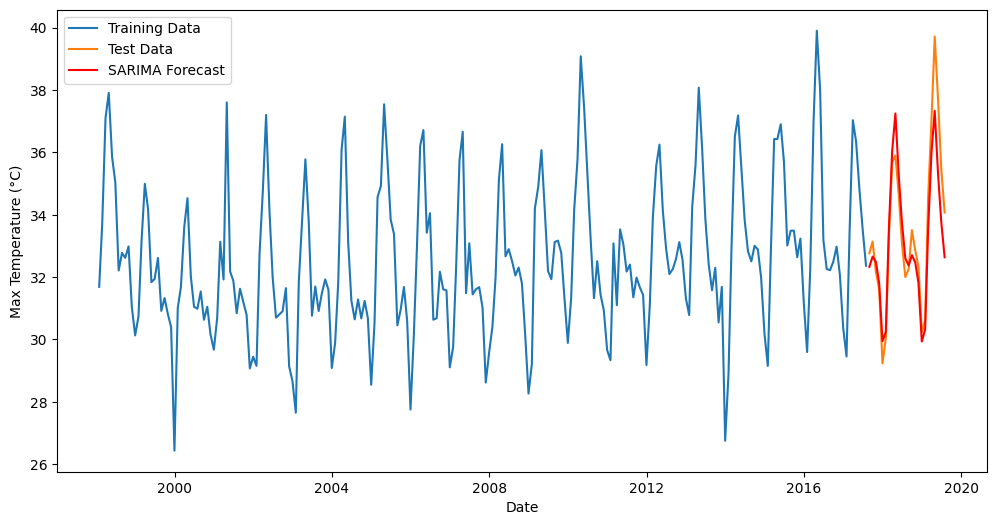

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# สร้างโมเดล SARIMA
sarima = SARIMAX(train, order=(0,1,4), seasonal_order=(1,1,1,12))

# fit โมเดล
sarima_fit = sarima.fit(optimized=True)

# ทำนายค่าในช่วง Test set
yhat = sarima_fit.predict(start=test.index[0], end=test.index[-1])

# plot ผลลัพธ์
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Test Data')
plt.plot(yhat.index, yhat, label='SARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Max Temperature (°C)')
plt.legend()
plt.show()



In [11]:
y = data['MaxTemp'].resample("M").mean()

/tmp/ipython-input-3759875875.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y = data['MaxTemp'].resample("M").mean()


In [12]:
def rmse(y_true,y_pred):
  # Inputs
  # y_true: actual value, y_pred: predicted values
  # Output: RMSE between y_true and y_pred
  return np.sqrt(np.mean(np.square(y_true-y_pred)))

In [13]:
train = y[:-24]
test = y[-24:]

print(test)

Date
2017-08-31    32.764516
2017-09-30    33.140000
2017-10-31    32.158065
2017-11-30    31.616667
2017-12-31    29.229032
2018-01-31    30.048387
2018-02-28    33.253571
2018-03-31    35.674194
2018-04-30    35.900000
2018-05-31    34.648387
2018-06-30    33.066667
2018-07-31    32.000000
2018-08-31    32.258065
2018-09-30    33.506667
2018-10-31    32.864516
2018-11-30    32.336667
2018-12-31    30.229032
2019-01-31    30.622581
2019-02-28    34.564286
2019-03-31    37.051613
2019-04-30    39.716667
2019-05-31    37.680645
2019-06-30    35.466667
2019-07-31    34.070968
Freq: ME, Name: MaxTemp, dtype: float64
